In [18]:
import torch
import torchaudio
import torchaudio.transforms as transforms
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [32]:
def get_dataset(dataset):
    # DataLoader 설정 (배치 크기=4, 셔플=True)
    return DataLoader(dataset, batch_size=4, shuffle=True)

def show_dataset(dataloader): 
        # 배치 단위로 데이터 로드
    for batch in dataloader:
        waveforms, sample_rates = batch
        print(f"Batch waveforms shape: {waveforms.shape}")  # (배치, 채널, 샘플 수)
        print(f"Batch sample rates: {sample_rates}")
        
def plot_waveform(waveform, sample_rate, title="Waveform"):
    plt.figure(figsize=(10, 3))
    plt.plot(waveform.t().numpy())  # (채널, 샘플 수) → (샘플 수)
    plt.title(f"{title} (Sample Rate: {sample_rate} Hz)")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

def plot_spectrogram(spec, title="Spectrogram"):
    plt.figure(figsize=(10, 4))
    plt.imshow(spec.log2()[0].detach().numpy(), aspect="auto", origin="lower")
    plt.title(title)
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Frequency")
    plt.colorbar(label="Log Power")
    plt.show()

In [29]:
os.listdir("./upload_file")

['0002.mp3']

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, audio_dir, transform=None):
        """
        오디오 파일을 Dataset으로 변환하는 클래스
        
        :param audio_dir: 오디오 파일이 저장된 디렉토리 경로
        :param transform: 오디오 데이터에 적용할 변환 (예: Resampling, MelSpectrogram 등)
        """
        self.audio_dir = audio_dir
        self.audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.mp3')]  # WAV 파일만 사용
        self.transform = transform

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        """
        :param idx: 데이터 인덱스
        :return: (waveform, sample_rate)
        """
        audio_path = os.path.join(self.audio_dir, self.audio_files[idx])
        waveform, sample_rate = torchaudio.load(audio_path)  # 오디오 파일 로드

        if self.transform:
            waveform = self.transform(waveform)  # 변환 적용

        return waveform, sample_rate

In [14]:
# 데이터셋 폴더 지정 (오디오 파일이 저장된 경로)
audio_dir = "./upload_file"

# 데이터셋 생성
dataset = AudioDataset(audio_dir)

# 첫 번째 데이터 가져오기
waveform, sample_rate = dataset[0]

# 출력
print(f"Waveform shape: {waveform.shape}")  # (채널, 샘플 수)
print(f"Sample rate: {sample_rate}")

Waveform shape: torch.Size([1, 7977600])
Sample rate: 22050


# 샘플링 수를 줄이는방법


## Resampling이란?

오디오 데이터의 샘플링 레이트(Sample Rate)를 변경하는 과정입니다.

- **샘플링 레이트란?**  
  초당 오디오 신호를 몇 번 측정하는지 나타내는 값(Hz).

  예:
  - CD 품질: 44.1kHz (44100Hz)
  - 전화 음성: 8kHz (8000Hz)
  - 고품질 오디오: 48kHz (48000Hz)

- **Resampling을 하는 이유:**  
  1. **데이터 일관성** – 다양한 샘플링 레이트를 통일  
  2. **연산 비용 감소** – 필요 이상으로 높은 샘플링 레이트를 낮춰 메모리 사용량 절감  
  3. **모델 요구 사항 충족** – 특정 샘플링 레이트(예: 16kHz)로 입력을 맞춤  

---

## Mel Spectrogram이란?

오디오 신호를 **시각적 데이터(스펙트로그램)**로 변환하는 방법입니다.

- 오디오는 **시간(time) + 주파수(frequency)**의 정보가 포함됨  
- 하지만 원본 오디오 신호는 모델이 직접 이해하기 어려움 → 스펙트로그램 변환 필요  
- **Mel Scale(멜 스케일)**을 사용하면 인간의 청각 특성을 반영한 주파수 변환이 가능  

### Mel Spectrogram 변환 과정

1. **STFT (Short-Time Fourier Transform) 적용**  
   - 오디오 신호를 짧은 구간으로 나눠 각각의 주파수를 분석  

2. **주파수 데이터를 Mel Scale로 변환**  
   - 인간의 청각은 고주파보다 저주파를 더 민감하게 인식  
   - 일반 주파수(Frequency) → Mel 주파수로 변환  

3. **데이터 정규화**  
   - 로그 스케일(Log Scale) 적용 → 더 나은 특징 추출 가능  

Batch waveforms shape: torch.Size([1, 1, 2659200])
Batch sample rates: tensor([22050])
Batch waveforms shape: torch.Size([1, 1, 64, 39889])
Batch sample rates: tensor([22050])


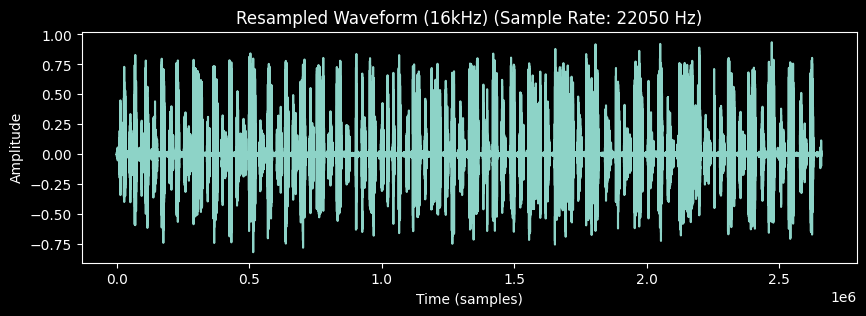

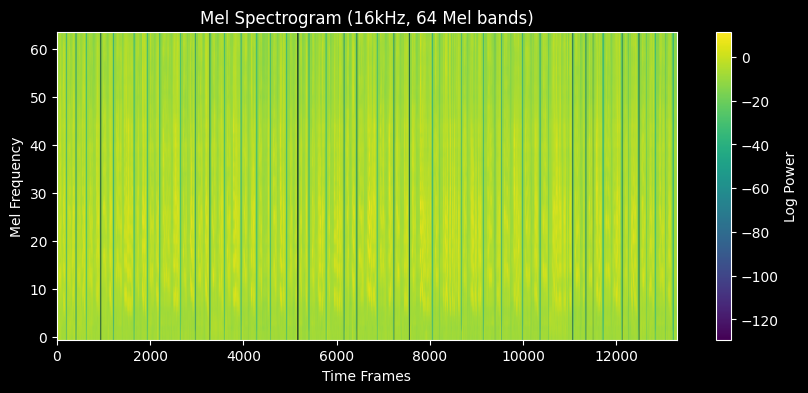

In [43]:

# Resampling 변환 (48kHz → 16kHz)
resample_transform = transforms.Resample(orig_freq=48000, new_freq=16000)

# Mel Spectrogram 변환 (16kHz 기준)
mel_transform = transforms.MelSpectrogram(sample_rate=16000, n_mels=64)

# Resampling & Mel Spectrogram 적용된 데이터셋 생성
dataset_resampled = AudioDataset(audio_dir, transform=resample_transform)
dataset_mel = AudioDataset(audio_dir, transform=mel_transform)

# DataLoader로 배치 데이터 로드
dataloader_resampled = get_dataset(dataset_resampled)
dataloader_mel = get_dataset(dataset_mel)

show_dataset(dataloader_resampled)
show_dataset(dataloader_mel)

# 첫 번째 배치 데이터 가져오기
waveform_resampled, sample_rate_resampled = next(iter(dataloader_resampled))
waveform_mel, sample_rate_mel = next(iter(dataloader_mel))

# 원본 Waveform 시각화
plot_waveform(waveform_resampled[0], sample_rate_resampled[0], "Resampled Waveform (16kHz)")

# Mel Spectrogram 시각화
mel_spec_transform = transforms.MelSpectrogram(sample_rate=16000, n_mels=64)
mel_spec = mel_spec_transform(waveform_resampled[0])
plot_spectrogram(mel_spec, "Mel Spectrogram (16kHz, 64 Mel bands)")

# 모델 학습 하기 

In [46]:
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

device = "mps"

# Wav2Vec2 모델 및 프로세서 로드
processor = Wav2Vec2Processor.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")
model = Wav2Vec2ForCTC.from_pretrained("kresnik/wav2vec2-large-xlsr-korean").to(device)

# 오디오 파일 로드 및 Resampling
def load_audio(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)

    # Resampling (16kHz로 변환)
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
    return waveform, 16000

# Wav2Vec2를 사용한 음성 → 텍스트 변환
def speech_to_text(audio_path):
    waveform, sample_rate = load_audio(audio_path)

    # Wav2Vec2 입력 형식으로 변환 (GPU에서 실행)
    input_values = processor(
        waveform.squeeze(), return_tensors="pt", sampling_rate=sample_rate
    ).input_values.to(device)  # GPU로 이동

    # 너무 긴 입력 방지
    if input_values.shape[1] > 300000:
        print("⚠️ 입력 크기 초과! 잘라서 처리 중...")
        input_values = input_values[:, :300000]

    # 모델을 통해 예측 수행 (GPU에서 실행)
    with torch.no_grad():
        logits = model(input_values).logits

    # 예측값을 텍스트로 변환
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]

    return transcription

# 4내 음성 파일 학습 결과 출력
audio_file = "./upload_file/0002.mp3"  # 학습할 음성 파일
result = speech_to_text(audio_file)
print(f"음성 인식 결과: {result}")

⚠️ 입력 크기 초과! 잘라서 처리 중...
음성 인식 결과: 누슨 건강한가요 내 건강해어디를 닥쳤어요 무릎게 가졌어언제 닥쳤어요 한 을길 전이었니요


In [1]:
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

device = "mps"

# Wav2Vec2 모델 및 프로세서 로드
processor = Wav2Vec2Processor.from_pretrained("naseunghoo/wav2vec2-korean-finetuned")
model = Wav2Vec2ForCTC.from_pretrained("naseunghoo/wav2vec2-korean-finetuned").to(device)

# 오디오 파일 로드 및 Resampling
def load_audio(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)

    # Resampling (16kHz로 변환)
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
    return waveform, 16000

# Wav2Vec2를 사용한 음성 → 텍스트 변환
def speech_to_text(audio_path):
    waveform, sample_rate = load_audio(audio_path)

    # Wav2Vec2 입력 형식으로 변환 (GPU에서 실행)
    input_values = processor(
        waveform.squeeze(), return_tensors="pt", sampling_rate=sample_rate
    ).input_values.to(device)  # GPU로 이동

    # 너무 긴 입력 방지
    if input_values.shape[1] > 300000:
        print("⚠️ 입력 크기 초과! 잘라서 처리 중...")
        input_values = input_values[:, :300000]

    # 모델을 통해 예측 수행 (GPU에서 실행)
    with torch.no_grad():
        logits = model(input_values).logits

    # 예측값을 텍스트로 변환
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]

    return transcription

# 4내 음성 파일 학습 결과 출력
audio_file = "./upload_file/0002.mp3"  # 학습할 음성 파일
result = speech_to_text(audio_file)
print(f"음성 인식 결과: {result}")

/Users/naseunghoo/.pyenv/versions/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⚠️ 입력 크기 초과! 잘라서 처리 중...
음성 인식 결과: 요즘 건강한가요네[unk] 건강해요[unk]  어디를 다쳤어요무릎이 끄졌어요[unk] 언제 다쳤어요한 일주일 전이요[unk] [unk]


# fine-tunning 하기 위해서 모델 준비 

In [8]:
from pydub import AudioSegment
# MP3 파일을 WAV로 변환
def convert_mp3_to_wav(mp3_path, wav_path):
    audio = AudioSegment.from_mp3(mp3_path)
    audio.export(wav_path, format="wav")

# 예시: 변환 실행
convert_mp3_to_wav("./upload_file/0002.mp3", "./upload_file/example.wav")

# 음성파일을 작은 단위로 쪼개기

- 무음을 기준으로 텍스트 파일 분리해서 학습 데이터를 생성 
- 음성의 텍스트는 위스퍼를 통해서 테스트 파일 생성

In [ ]:
import torchaudio

# JSON 데이터를 데이터셋으로 변환
data = [
    {"audio_path": "./train/chunk_1.wav", "text": "요즘 건강한가요?"},
]
dataset = Dataset

# 오디오 파일 로드 및 처리 함수
def preprocess_data(batch):
    # 오디오 파일 로드
    audio, sampling_rate = torchaudio.load(batch["audio_path"])
    # 모델 샘플링 레이트로 변환 (16kHz)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    batch["input_values"] = resampler(audio).squeeze(0).numpy()
    return batch

# 데이터셋 전처리
dataset = dataset.map(preprocess_data)